In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit                

In [7]:
##### NOTE: For some reason it is necessary to execute this cell multiple times
#####       in order to display plots in notebooks correctly. 
#####       Nevertheless, the saved plot is correct at the first iteration. 
import sys
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls

# Initialize variables
B0_M = RooRealVar("B0_FitDaughtersConst_M", "B0_M", 5280, "MeV")
#upper_limit_mass = 5330
#lower_limit_mass = 5230
upper_limit_mass = 5350
lower_limit_mass = 5220
mass = RooRealVar("B0_FitDaughtersConst_M", "Mass(J/psi K_{S})", 5280,lower_limit_mass, upper_limit_mass, "MeV")
# Construct signal from two Gaussian pdf's with different means and sigmas 
mean = RooRealVar("mean", "mean", 5280,  5200,5360)
sigma_1 = RooRealVar("sigma_1", "sigma_1", 15, 0, 30)
sigma_2 = RooRealVar("sigma_2", "sigma_2", 20, 0, 30)
sig1frac = RooRealVar("sig1frac","fraction of component 1 in signal",0.5,0.,1.)

signal_1 = RooGaussian("signal_1", "signal_1", mass, mean, sigma_1)
signal_2 = RooGaussian("signal_2", "signal_2", mass, mean, sigma_2)
signal = RooAddPdf("signal","signal",signal_1, signal_2,sig1frac)#,RooArgList(mean,sigma_1, sigma_2)) 
# Construct background pdfd
lambda_1= RooRealVar("lambda","lambda",0.0,-0.2,0.0)
background = RooExponential("background","background",mass,lambda_1)
# Construct composite pdf
nsig = RooRealVar("nsig", "nsig", 110000,0,400000)#, 0, 100000)
nbkg = RooRealVar("nbkg", "nbkg", 800000, 0, 1400000)
model = RooAddPdf("model", "model", RooArgList(signal, background), RooArgList(nsig, nbkg))

In [8]:
# Read data and fit it
data = ROOT.TFile('/fhgfs/users/chasenberg/data/2016/jpsiks/sweights/Bd2JpsiKS_data_2016_flattened_SWeights.root')
tree_data = data.Get('Bd2JpsiKs') 
tree_data.GetEntries()

ntupleVarSet =  RooArgSet(mass)
dataset = RooDataSet('data','data',tree_data,ntupleVarSet)
#Fit model to dataset
model.fitTo(dataset, ROOT.RooFit.Save(True)) 

<ROOT.RooFitResult object ("fitresult_model_data") at 0x74f4130>

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


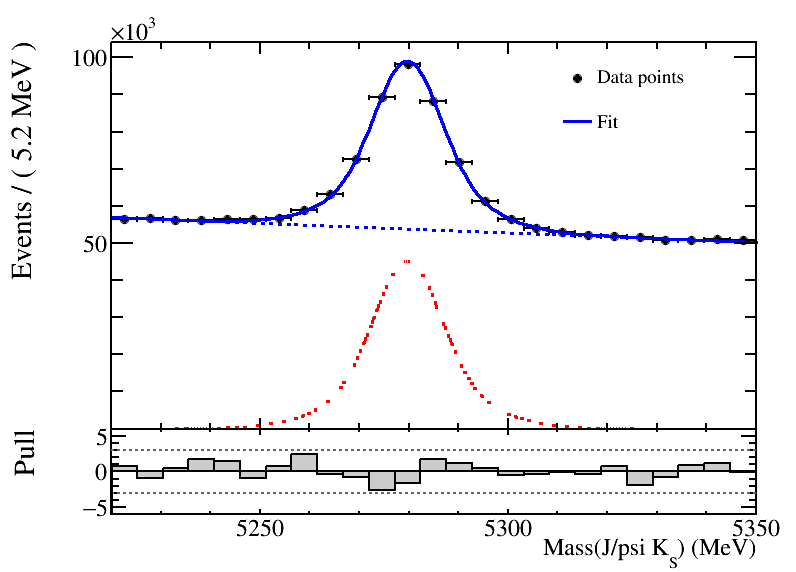

In [11]:
# Prepare frame
%matplotlib inline  
import ROOT
frame = mass.frame(ROOT.RooFit.Bins(25))

dataset.plotOn(frame, ROOT.RooFit.Name("data1"))

model.plotOn( frame , ROOT.RooFit.Components("signal"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kRed))
model.plotOn( frame , ROOT.RooFit.Components("background"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
model.plotOn(frame, ROOT.RooFit.Name("fit"))
### Add additional informations to the plot
text_size = 0.035
# Create TLegend
legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9, '')
legend.AddEntry(frame.findObject('data1'), "Data points", "p");
legend.AddEntry(frame.findObject('fit'), 'Fit', 'l')
legend.SetTextSize(text_size)

# Create TLatex
'''latex = ROOT.TLatex(0.19, 0.8, '#splitline{Toy MC example}' + \
                                 '{#it{f}(x) = #frac{1}{#sigma #sqrt{2 #pi}}' + \
                                 ' e^{- 0.5 #left( #frac{x - #mu}{#sigma} #right)^{2}}}')'''
#latex.SetTextSize(text_size)

# Plot pulls
can, _ = plot_pulls('test', frame, legend=legend)#, latex=latex)
can.SaveAs("/home/chasenberg/repos/b2cc_sin2beta/notebooks/mass_fit/plots/jpsiks/2016/B0_Mass.pdf")
can  # To display plot in notebooks

In [10]:
from ROOT import RooStats

data_sweight = ROOT.RooStats.SPlot("sData","An SPlot", dataset,model, RooArgList(nsig, nbkg))
sWeight_sig =ROOT.RooDataSet("dataset_nsig","dataset_nsig", dataset, dataset.get(),"","nsig_sw")
sWeight_bkg = ROOT.RooDataSet("dataset_nbkg","dataset_nbkg", dataset, dataset.get(),"","nbkg_sw")